In [77]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [78]:
# data read 
words = open('/home/risal/X3s4c5/Makemore/names.txt','r').read().splitlines()

In [79]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [80]:
import random 
random.seed(42)
random.shuffle(words)

In [81]:
# build the dataset
block_size = 8 # context length 
def build_dataset(words):
    X, Y= [] , []
    
    for w in words:
        context  = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_trn, Y_trn = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_tst, Y_tst = build_dataset(words[n2:])

In [82]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in **0.5 # kamming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias 
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps 
        self.momentum = momentum 
        self.training = True
        # Parameters 
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffer 
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim= (0,1)
            xmean = x.mean(dim, keepdim = True)
            xvar = x.var(dim, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) 
        self.out = self.gamma  * xhat + self.beta
        # update buffers 
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean 
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n 
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

class Sequential: # Pytorch container
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [83]:
torch.manual_seed(42);

In [84]:
n_emb = 10
n_hidden = 70

model = Sequential([
    Embedding(vocab_size, n_emb),
    FlattenConsecutive(2), Linear(n_emb * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])
                 
with torch.no_grad():
    model.layers[-1].weight *= 0.1 

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad =  True

23607


In [92]:
for layer in model.layers:
    print(layer.__class__.__name__,  ':', tuple(layer.out.shape))

Embedding : (1, 8, 10)
FlattenConsecutive : (1, 4, 20)
Linear : (1, 4, 70)
BatchNorm1d : (1, 4, 70)
Tanh : (1, 4, 70)
FlattenConsecutive : (1, 2, 140)
Linear : (1, 2, 70)
BatchNorm1d : (1, 2, 70)
Tanh : (1, 2, 70)
FlattenConsecutive : (1, 140)
Linear : (1, 70)
BatchNorm1d : (1, 70)
Tanh : (1, 70)
Linear : (1, 27)


In [86]:
# MLP
max_steps = 200000
batch_size = 32
losses_train = []

for i in range(max_steps):
    
    # mini batch
    ix = torch.randint(0,X_trn.shape[0], (batch_size,))
    Xb, Yb = X_trn[ix], Y_trn[ix]
    
    # forward passes 
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) 

    # backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params (using simmple SGD)
    lr = 0.01 if i < 150000 else 0.001
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d} / {max_steps:7d}: {loss.item():.4f}")
    losses_train.append(loss.item())

    # break

      0 /  200000: 3.2840
  10000 /  200000: 2.2190
  20000 /  200000: 2.4536
  30000 /  200000: 2.1879
  40000 /  200000: 1.9964
  50000 /  200000: 2.4355
  60000 /  200000: 2.1421
  70000 /  200000: 2.4316
  80000 /  200000: 2.4204
  90000 /  200000: 1.8474
 100000 /  200000: 1.8980
 110000 /  200000: 1.9596
 120000 /  200000: 2.1868
 130000 /  200000: 2.1598
 140000 /  200000: 2.3438
 150000 /  200000: 1.9072
 160000 /  200000: 2.0396
 170000 /  200000: 1.8781
 180000 /  200000: 1.8716
 190000 /  200000: 2.0179


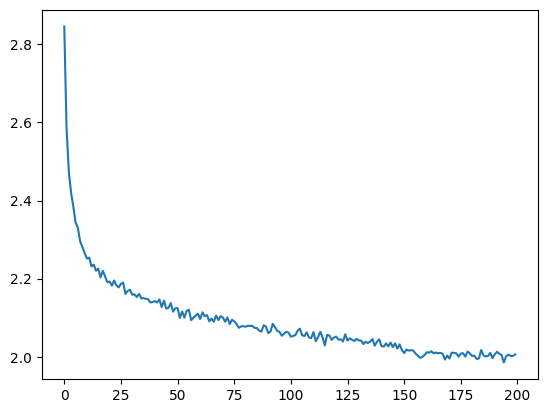

In [87]:
plt.plot(torch.tensor(losses_train).view(-1,1000).mean(1))

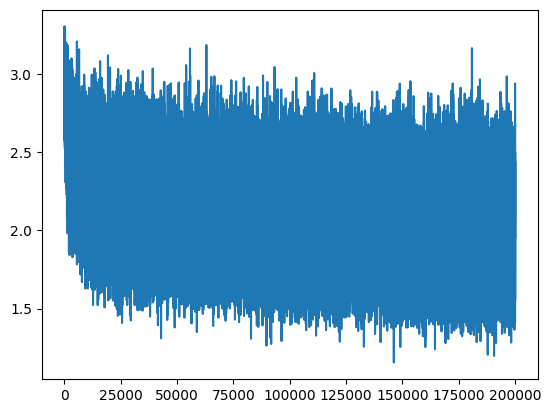

In [88]:
plt.plot(losses_train)

In [89]:
# Put layers into eval mode 
for layer in model.layers:
    layer.training = False

In [90]:
@torch.no_grad()
def split_loss(split):
    count = 0
    X,y = {
        'train': (X_trn, Y_trn),
        'val' : (X_dev, Y_dev),
        'test' : (X_tst, Y_tst),
    }[split]
    logits = model(X)
    loss = F.cross_entropy(logits, y) 
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.974591851234436
val 2.046088695526123


In [91]:
for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context])) 
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1, replacement = True).item()
        # shift context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out)) # decade and print the generate word

alexsia.
akyla.
karose.
loveen.
lavare.
zeiah.
yanna.
kayleh.
uspbeyria.
anah.
javea.
klissana.
shivon.
delina.
caitya.
muhina.
kie.
danelle.
rai.
phian.
